# 1. Environment Set-up

## Install & Load Packages

In [235]:
# Packages Installation
!pip install -U -q PyDrive
!pip install transformers
!pip install emoji
!pip install spacy
!pip install scikit-learn
!pip install -U sentence-transformers
!pip install pandasql
!pip install pytorch-ignite 
!pip install -U sentence-transformers
!pip install soyclustering
!git clone https://github.com/lovit/kmeans_to_pyLDAvis
!pip install pyldavis
!pip install chart_studio
!pip install shap 
!pip install catboost 

# Google Drive Related pacakges
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# General
import random
import time
from datetime import datetime, timedelta
from tqdm import tqdm
import string
import sys
sys.path.append("/content/kmeans_to_pyLDAvis")
import os

# General Data Maniuplation Packages
import numpy as np
import pandas as pd
import pandasql as ps
import concurrent.futures
import pyLDAvis.sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Scikit & Other ML Packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from soyclustering import SphericalKMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import xgboost as xgb

# Plotting Related
import matplotlib.pyplot as plt
import seaborn as sns
import kmeans_to_pyLDAvis
from kmeans_to_pyLDAvis import kmeans_to_prepared_data
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
%matplotlib inline

# Plotly based imports for visualization
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import shap 

#### NLP Related Packages
# Regular Expression
import re

# PyTorch & Transformer
import torch
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

# Ignite
import ignite
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

# Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.tokens import Doc
from spacy.language import Language
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = Tokenizer(nlp.vocab)

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

fatal: destination path 'kmeans_to_pyLDAvis' already exists and is not an empty directory.


## Load Data

In [236]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1OP4Np3DfyjoyNDnMSL4ir1WqRveSEu_n'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data tweets.csv')

id = '1Rz8UkM9996v3kdML8zAeCIj8Zka80Ll-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data NEC prices.csv')

id = '1KTk7j5EhAQGjHZpSyS2A7IOWfphNcK3z'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data SVW prices.csv')

id = '1_2M_v7W5Ai3vZEEAfZmjaZu1z7Y9Nzbq'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Affiliated_Company.csv')

In [237]:
NEC = pd.read_csv("data NEC prices.csv")
SVW = pd.read_csv("data SVW prices.csv")
tweets = pd.read_csv("data tweets.csv",encoding='ISO-8859-1')

# Import Affiliated Companies of each Twitter User, this is not provided

# Rather, it's collected by myself 
company = pd.read_csv("Affiliated_Company.csv")
company['Name'] =company['Name'].str.strip() 

# Data Preparation

## Tweets Data

In [238]:
# Remove re-tweets as they are lagging indicator
data = tweets[tweets['retweet'] == 'FALSE'].reset_index(drop=True)

# Keep only relevant columns, a lot of other columns could be lagging indicator, such as likes etc.
data = data[['name','tweet_post_time','tweet_text']]

In [239]:
# Break Date Time into separated columns for the tweets Data
TS = []

Date_time = data['tweet_post_time'].str.split().reset_index(drop = True)

for i in range(len(Date_time)):
  Day = int(Date_time[i][0].split('/')[0])
  Month = int(Date_time[i][0].split('/')[1])
  Year = int(Date_time[i][0].split('/')[2])
  Hour = int(Date_time[i][1].split(':')[0])
  Minute = int(Date_time[i][1].split(':')[1])

  ts = datetime(Year,Month,Day,hour=Hour,minute=Minute)
  TS.append(ts)

Date_Time = pd.DataFrame(np.array(TS).T,columns=['TS'])
data = pd.concat((data,Date_Time),sort=False,axis=1).drop(columns=['tweet_post_time'])

The time shown in Tweets data is in UTC, whereas the one in the share price data is in Sydney Time / GMT.

Since the stocks is traded in Sydney Time, we will convert UTC to Sydney Time. 

In [240]:
data['TS'] = data['TS'] + timedelta(hours=10)

In [241]:
# Remove duplicated Tweets
data = data.sort_values('TS').reset_index(drop=True)
data = data.drop_duplicates('tweet_text').reset_index(drop=True)

## NEC Share Price Data

In [242]:
# Load Data
NEC = pd.read_csv("data NEC prices.csv")

# Break Date Time into separated columns for the NEC share price Data
TS = []
Time = []

Date_time = NEC['SrcTime'].str.split('T').reset_index(drop = True)

for i in range(len(Date_time)):
  Day = int(Date_time[i][0].split('/')[0])
  Month = int(Date_time[i][0].split('/')[1])
  Year = int(Date_time[i][0].split('/')[2])
  Hour = int(Date_time[i][1].split(':')[0])
  Minute = int(Date_time[i][1].split(':')[1])

  ts = datetime(Year,Month,Day,hour=Hour,minute=Minute)
  TS.append(ts)
  Time.append(ts.time())
 
Date_Time = pd.DataFrame(np.vstack((np.array(TS),np.array(Time))).T,columns=['TS_Open','Time'])
NEC = pd.concat((NEC,Date_Time),sort=False,axis=1).drop(columns=['SrcTime','Exchange','GMT','High','Low','Volume','Value','Transactions','Code'])

In [243]:
NEC['TS_Close'] = NEC['TS_Open'] + timedelta(minutes=10)

In [244]:
print('The ASX Stock Market Opens At ' + str(min(set(NEC['Time']))))
print('The ASX Stock Market Close At ' + str(max(set(NEC['Time']))))

The ASX Stock Market Opens At 10:00:00
The ASX Stock Market Close At 16:10:00


In [245]:
NEC = NEC.sort_values(by=['TS_Open']).reset_index(drop=True)
print(NEC[NEC['Time'].apply(str) == '16:00:00']) 

       Open  Close             TS_Open      Time            TS_Close
5159  229.0  229.0 2021-01-18 16:00:00  16:00:00 2021-01-18 16:10:00
6270  308.0  309.0 2021-03-02 16:00:00  16:00:00 2021-03-02 16:10:00
6678  296.0  296.0 2021-03-17 16:00:00  16:00:00 2021-03-17 16:10:00
7381  290.0  290.0 2021-04-15 16:00:00  16:00:00 2021-04-15 16:10:00
9120  304.0  303.5 2021-06-22 16:00:00  16:00:00 2021-06-22 16:10:00


Seems like the time block between 16:00 to 16:10 is missing for most the dates. We will add them into the data manually

In [246]:
Open = []
Close = []
TS_Open = []
Time = []
TS_Close = []

for i in range(len(NEC)):
  if (str(NEC['Time'][i]) == '16:10:00') and (str(NEC['Time'][i-1]) != '16:00:00'):

    Open.append(NEC['Close'][i-1])
    TS_Open.append(NEC['TS_Close'][i-1]) 
 
    Close.append(NEC['Open'][i]) 
    TS_Close.append(NEC['TS_Open'][i])

    Time.append((NEC['TS_Open'][i]-timedelta(minutes=10)).time())

extra_rows = pd.DataFrame(np.vstack((np.array(Open),np.array(Close),np.array(TS_Open),np.array(Time),np.array(TS_Close))).T,columns=['Open','Close','TS_Open','Time','TS_Close'])
NEC = pd.concat((NEC,extra_rows),sort=False,axis=0)
NEC = NEC.sort_values(by=['TS_Open']).reset_index(drop=True)

In [247]:
# Check
print(NEC[NEC['Time'].apply(str) == '16:00:00'])

       Open  Close             TS_Open      Time            TS_Close
36    138.0  138.0 2020-07-01 16:00:00  16:00:00 2020-07-01 16:10:00
74    138.5  138.5 2020-07-02 16:00:00  16:00:00 2020-07-02 16:10:00
112   138.0  138.5 2020-07-03 16:00:00  16:00:00 2020-07-03 16:10:00
150   137.5  138.0 2020-07-06 16:00:00  16:00:00 2020-07-06 16:10:00
188   135.5  136.0 2020-07-07 16:00:00  16:00:00 2020-07-07 16:10:00
...     ...    ...                 ...       ...                 ...
9246  301.0  300.0 2021-06-17 16:00:00  16:00:00 2021-06-17 16:10:00
9284  304.0  304.0 2021-06-18 16:00:00  16:00:00 2021-06-18 16:10:00
9322  296.5  296.0 2021-06-21 16:00:00  16:00:00 2021-06-21 16:10:00
9360  304.0  303.5 2021-06-22 16:00:00  16:00:00 2021-06-22 16:10:00
9398  299.0  300.0 2021-06-23 16:00:00  16:00:00 2021-06-23 16:10:00

[246 rows x 5 columns]


In [248]:
# Filter out Share Price After 16:10, as the market has been closed, and there is no price movement
print(len(NEC[(NEC['Time'].apply(str) == '16:10:00') & (NEC['Open']!=NEC['Close'])]) == 0)
NEC = NEC[NEC['Time'].apply(str) != '16:10:00'].reset_index(drop=True)

True


## Meger Share Price Data & Tweets Data

In [249]:
# Merge Share Price Data with Tweets Data
sqlcode = '''
select * 
from data
left join NEC on data.TS >= NEC.TS_Open and data.TS < NEC.TS_Close 
'''

data_merged = ps.sqldf(sqlcode,locals())

In [250]:
# Check there is no dupliacted rows
len(data_merged)==len(data)

True

In [251]:
# Filter out tweets that was not attached to any of the share price time block
data_merged = data_merged[~(data_merged['Time'].isnull())]

In [252]:
print('Time sent of the earliest Tweet that has a share price attached ' + str(min(set(data_merged['TS']))))
print('Time sent of the latest Tweet that has a share price attached ' + str(max(set(data_merged['TS']))))
print('The time does align with the pre-define period which the data was collected from.')

Time sent of the earliest Tweet that has a share price attached 2020-07-01 12:02:00.000000
Time sent of the latest Tweet that has a share price attached 2021-06-23 15:44:00.000000
The time does align with the pre-define period which the data was collected from.


Summarise Results

In [253]:
# Remove duplicated Tweets
data_merged = data_merged.sort_values('TS').reset_index(drop=True)
data_merged = data_merged.drop_duplicates('tweet_text').reset_index(drop=True)

In [254]:
# Count number of unique users
print("# of Unique Users: " + str(len(set(data_merged['name']))))

# of Unique Users: 49


In [255]:
# Merge affiliated companies onto each user
data_merged = pd.merge(data_merged,company,how="left",left_on='name',right_on='Name')

In [256]:
# Count number of tweets by users
agg = data_merged.groupby(['name','Company']).agg(['count'])
print(agg.to_string())

                                    tweet_text    TS  Open Close TS_Open  Time TS_Close  Name Currently_In  Type
                                         count count count count   count count    count count        count count
name                     Company                                                                                
#DancingAU               SVW                30    30    30    30      30    30       30    30            0    30
60 Minutes Australia     NEC               371   371   371   371     371   371      371   371            0   371
7AFL                     SVW               413   413   413   413     413   413      413   413            0   413
7Cricket                 SVW               476   476   476   476     476   476      476   476            0   476
7NEWS Australia          SVW               599   599   599   599     599   599      599   599            0   599
9News Australia          NEC               450   450   450   450     450   450      450   450   

In [257]:
# Create Flag to indicate whether the tweets is from Competitor or from NEC
data_merged['Competitor'] = 0

for i in range(len(data_merged['Company'])):
  if data_merged['Company'][i] != 'NEC':
   data_merged['Competitor'][i] = 1

In [258]:
NEC['Close']/NEC['Open']

0       0.998195
1       0.994585
2       1.001815
3        1.00722
4            1.0
          ...   
9149    1.001667
9150    1.001664
9151    0.998339
9152    0.995008
9153    1.003344
Length: 9154, dtype: object

In [259]:
# Calcuate Market Movement
market_movements = abs(NEC['Close']/NEC['Open'] - 1)
print(np.percentile(market_movements,85))

0.005291005291005346


(array([2.90e+03, 2.84e+03, 1.61e+03, 6.86e+02, 5.33e+02, 1.97e+02,
        1.41e+02, 1.03e+02, 5.70e+01, 4.40e+01, 9.00e+00, 1.30e+01,
        1.00e+01, 3.00e+00, 6.00e+00, 3.00e+00, 1.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([0.0, 0.0014921946740128538, 0.0029843893480257077,
        0.0044765840220385615, 0.005968778696051415, 0.007460973370064269,
        0.008953168044077123, 0.010445362718089976, 0.01193755739210283,
        0.013429752066115686, 0.014921946740128538, 0.01641414141414139,
        0.017906336088154246, 0.0193985307621671, 0.020890725436179952,
        0.022382920110192807, 0.02387511478420566, 0.025367309458218516,
        0.02685950413223137, 0.028351698806244222, 0.029843893480257077,
        0.03133608815426993, 0.03282828282828278, 0.03432047750229564,
        0.03581267217

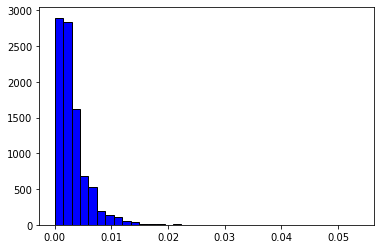

In [260]:
# matplotlib histogram
plt.hist(market_movements, color = 'blue', edgecolor = 'black',bins = int(180/5))

# Response Variable (Question 4a)

The share price data was extracted at 10-min interval, thus we can only do back testing using opening and closing price at the 10-min interval. 

The response variable would be the price movement after each tweet was sent. In particular, we will categorise each tweets into the following 3 categories:

1.   Increase | (close price / opening price - 1) >= 0.5%, and this will trigger a buy action.
2.   Decrease | (close price / opening price - 1) <= -0.5%, and this will trigger a sell action.
3.   Unchanged | -0.5% < (close price / opening price - 1) < 0.5% and no buy/sell action will be triggered.

The close price and open price are from the 10-min interval which the tweet was sent.

The 0.5% price movement threshold was chosen as it is around the 85th percentile of all price movement. 

+ The higher the threshold, the less likely that share price moved was due to noise, and more likely the share price moved due to the influence of the tweets.

- On the flip side, the higher the threshold, then we have less data with 'Increased' or 'Decreased' as the label. 



## Assumptions

1.  We will assume the brokage fee = 5 dps = 0.05%, this amount is quite typical for active fund. Thus, for a buy + sell transcations this will cost ~0.1% (0.05% * 2).
2.  We are allowed to short sell.  
3.  At the time of each tweet was sent, the price of the share stayed unchanged from the open price of the 10-min interval in which the tweet was sent. This assumption has to be made because we can't access real-time price data.

## Implementation Constraints

Assumption 3 is obvious unrealistic, so during implementation, if we can access real-time data with much shorter interval, following check will be performed on the share price at time the tweet was sent:

*   If the model predicted price movement = "Increase", then we will check whether the share price has already increase by more than 0.5% - 0.1% (brokage fees * 2) from the opening price. And if that is the case, even if the model predicted the price movement correctly, the potential profit from the transaction might not be enough to cover the brokage fees, thus no buy action will be triggered.   

*   If the model predicted price movement = "Decrease", then we will check whether the share price has already decreased by more than 0.5% - 0.1% (brokage fees * 2) from the opening price. Similarly, if that the is case, then no sell action will be triggered.

*   If the model predicted price movement = "Unchanged", no check will be peformed, and no buy/sell aciton will be triggered.

In [261]:
# Create Response Variable
data_merged['Move'] = data_merged['Close']/data_merged['Open'] - 1 

for i in range(len(data_merged['Move'])):
  if data_merged['Move'][i] >= 0.005:
     data_merged['Move'][i] = 2
  elif data_merged['Move'][i] <= -0.005:
     data_merged['Move'][i] = 0 
  else:
     data_merged['Move'][i] = 1

data_merged['Move'] = data_merged['Move'].astype(int) 

In [262]:
agg = data_merged.groupby(['Move']).agg(['count'])
print(agg.to_string())

      name tweet_text    TS  Open Close TS_Open  Time TS_Close  Name Company Currently_In  Type Competitor
     count      count count count count   count count    count count   count        count count      count
Move                                                                                                      
0      585        585   585   585   585     585   585      585   555     555           26   555        585
1     5768       5768  5768  5768  5768    5768  5768     5768  5507    5507          319  5507       5768
2      642        642   642   642   642     642   642      642   606     606           38   606        642


# 2. Data Pre-processing (Question 3a)

### 1. Cleaning

*   Remove unwanted word - "RT" & line changer "/n"
*   Emoji Encoding - convert emoji into texts that can understand by the Bertweet tokenizer
*   Normalization - Normalize words with the same meaning which can be written different such as "cannot" and "can not", this includes Converting user mentions and web/url links into special tokens "@USER" and "HTTPURL".
*   Isolate contraction - isolate contraction such as "I'm" to "I 'm" so that Bertweet can create a seperate token for the contraction.
*   Note that, stop words won't be removed here, as we will be using BERT to encode the tweets into word embedding, which does not reuqire stop words to be removed

#### 2. Lemmatization 

*   Lemmatization was done purely to show that I know how to lemmatize the texts
*   BERTweet does not need lemmatization as it use fast Byte-Pair Encoding (BPE) to tokenize the texts
*   Thus, the lemmatizatized words here will not be used anywhere in the rest of the analysis

#### 3. Tokenisation 

*   We will use the tokenizer that was used to train BERTweet, which is a sub-word tokenizer using fastBPE.

#### 4. Vectorise 

*   Once the words have been tokenized, we will pass it into BERTweet, which will vectorise the words into 768 dimensions
*   BERTweet subject to a max length of 128 tokens, so we will truncate the tweets to 128 tokens if it contains more than that amount.

@inproceedings

{bertweet,

title     = {{BERTweet: A pre-trained language model for English Tweets}},

author    = {Dat Quoc Nguyen and Thanh Vu and Anh Tuan Nguyen},

booktitle = {Proceedings of the 2020 Conference on Empirical Methods in Natural
 Language Processing: System Demonstrations},

year      = {2020},

pages     = {9--14}
}









In [30]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
bertweet = AutoModel.from_pretrained("vinai/bertweet-covid19-base-cased").to(device)
bertweetokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-covid19-base-cased", use_fast=True)
smodel = SentenceTransformer('all-mpnet-base-v2').to(device)

from nltk.tokenize import TweetTokenizer
from emoji import demojize
import re

tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def CleanTweet(tweet):
  
    tokens = tokenizer.tokenize(tweet.encode("ISO-8859-1").decode('utf-8','ignore').replace("’", "'").replace("…", "...").replace("/n", ""))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll ", " 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.") .replace(" p . m ", " p.m ").replace(" a . m .", " a.m.").replace(" a . m ", " a.m ")

    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    normTweet = re.sub(r"\bRT\b", "", normTweet)
    
    return " ".join(normTweet.split()), normTweet.split()
  
def CleanTweet_NoNorm(tweet):
  
    tokens = tokenizer.tokenize(tweet.encode("ISO-8859-1").decode('utf-8','ignore').replace("’", "'").replace("…", "...").replace("/n", ""))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll ", " 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.").replace(" p . m ", " p.m ").replace(" a . m .", " a.m.").replace(" a . m ", " a.m ")
    normTweet = normTweet.replace("@USER", "").replace("HTTPURL", "") 

    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    normTweet = re.sub(r"\bRT\b", "", normTweet)
    
    return " ".join(normTweet.split())

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-covid19-base-cased were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
def determine_max_length(data):
  max_len = 0
  for i in range(len(data)):
    tweet, _ = CleanTweet(data[i])

    with torch.no_grad():
      inputs = bertweetokenizer(tweet, return_tensors="pt")        
      model_output = bertweet(inputs['input_ids'].to(device))
      
    if max_len < model_output.last_hidden_state.cpu().shape[1]:
      max_len = model_output.last_hidden_state.cpu().shape[1]

  return max_len

def preprocess(data,max_len):
  sentence = []
  feature = []
  feature_no_pad = []
  tokens = []
  sent_emb = []

  for i in range(len(data)):
    lemma = []

    tweet, token = CleanTweet(data[i])
    tokens.append(token)

    for w in nlp(tweet):
      lemma.append(w.lemma_)    
    
    sent_emb.append(smodel.encode(' '.join(lemma)))
    sentence.append(' '.join(lemma))
      
    with torch.no_grad():
      inputs = bertweetokenizer(tweet, return_tensors="pt",padding=True,pad_to_multiple_of=max_len)
      model_output = bertweet(inputs['input_ids'].to(device))
      
    feature.append(model_output.last_hidden_state.cpu())

    with torch.no_grad():
      inputs = bertweetokenizer(tweet, return_tensors="pt")
      model_output = bertweet(inputs['input_ids'].to(device))

    feature_no_pad.append(model_output.last_hidden_state.cpu())

  return sentence, tokens, feature, sent_emb, feature_no_pad

## Run Pipeline

In [32]:
# Determine the maximum sequence length from data, No need to re-run once max_len has been determined
# Runtime: ~1 mins  
# max_len = determine_max_length(data_merged['tweet_text'])
# print("Maximum Sequence Length: " + str(max_len))

In [33]:
# Clean, lemmatize, tokenized, and vectorise (with padding to max_len) the text data 
# Runtime: ~2-3 mins  
sentence, tokens, feature, sentence_embeddings, feature_no_pad = preprocess(data_merged['tweet_text'],118)
feature = torch.cat(tuple(feature),dim=0) 
feature_no_pad = torch.squeeze(torch.cat(tuple(feature_no_pad),dim=1),axis=0)

Random Spot Checks on outputs

In [34]:
choice = random.choice(range(len(data_merged)))
print("Original Tweets:")
print(data_merged['tweet_text'][choice])
print("")
print("-------------------------------------------------------------------------------------")
print("Cleaned Sentence (with Lemmatisation):")
print(sentence[choice])
print("")
print("-------------------------------------------------------------------------------------")
print("Cleaned Tokens (without Lemmatisation as BERT will handle that):")
print(tokens[choice])
print("")
print("-------------------------------------------------------------------------------------")
print("Vectorised Word Embeddings:")
print(feature[choice].shape)
print("")
print("-------------------------------------------------------------------------------------")
print("Vectorised Sentence Embeddings:")
print(sentence_embeddings[choice].shape)

Original Tweets:
@TroyRatcliffe17 @7olympics @Channel7 @edwina_b @anniejowilliams @abbey_gelmi @mattshirvington @Mel_Mclaughlin @sthalekar93 @AndyMaherDFA @JaseRicho He will be in Tokyo..:)

-------------------------------------------------------------------------------------
Cleaned Sentence (with Lemmatisation):
@USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER -PRON- will be in Tokyo .. :)

-------------------------------------------------------------------------------------
Cleaned Tokens (without Lemmatisation as BERT will handle that):
['@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', '@USER', 'He', 'will', 'be', 'in', 'Tokyo', '..', ':)']

-------------------------------------------------------------------------------------
Vectorised Word Embeddings:
torch.Size([118, 768])

-------------------------------------------------------------------------------------
Vectorised Sentence Embeddings:
(768,)


# 3. Unsupervised Learning

## PCA (Question 3b)

PCA is a dimension reduction technique which has been widely used for that purpose. 

There are plenty of benefit of reducing the dimensions such as:

+ smaller data size, thus lower Storage Space & RAM requirement.

+ Faster computation speed for downstream process

+ Reduce overfitting

+ Allow user to visualize large amount of varaince on 2-D graph 

Following are some of the advantages and disadvantages that is more specfically relates to PCA:

Pros:
+ Flexiblity 

> User can specify the number of dimension that they wanted to keep depending on the % of original varaince explained, which is quite flexible.

> In the following example, where we applied the PCA to the Word Embedding, 90% of the variance can be explained by first 400 dimension, which about half of the original dimension of 768. Then I can keep tge 400 dimension only, and if I only wanted to keep 80% of the variance, I have the flexibility of keep < 400 dimension to achieve that.

+ Remove Correlation 

> Correlation can create some problems for machine learning models, PCA solved this problem as the reduced dimensions does not correlated to each other 

> In our case, we will be building a Tree-based model and explained with a Variable Importance Plot (VIP). And one problem with correlated data is that, correlation will distored the variable importancs in Tree-based model. For example, two significant but corrlated variables will share the significance and ended up ranked less important on the VIP. PCA in a way solve this problem for us.

Cons:
- Intertapability

> Princple Compoents (the reduced dimensions) are a linear combination of all the original features, and such relationship can be hard to understand initutively.

> In the VIP example above, although we have remove the problem of correlation, but now we only have the VIP consists of princple compoents, which is very hard to understand it initutively. Although, the input features are already BERT embedding which is hard to understand to start with, so this is not really a problem for our purpose.


- Information Loss

> Although PCA can retain large amount of variance with small number of dimension, it can never retain all the information unless the number of components were set to be the same as the original dimension, which then defeat the purpose of dimension reduction at the first place. 

> In our case, we are able to retain 90% (10% loss) of the information with dimension reduced to half of the original number of dimension, which is a pretty good result. 

- Trap of PCA:

> A lot of modeller apply PCA or other scalers to the whole dataset before splitting them into train / test dataset for model training purpose.

> However, unintentionally, this leads to some information flowed from the test dataset to the training dataset which may leads the model accuracy on test set to be higher than it should on an actual unseen dataset. 

> Having said that, I have decided to just apply it to the whole dataset, because that fits better with the order of the questions (modelling related questions got asked way later). Also I will be using k-fold cross-validaiton for hyper-parameter search, which means that I have to apply PCA k times, which might slow down my training process significantly. 

> Thus I just wanted to make it clear that I purpose fell for this PCA trap, and noted that my test accuracy might be slightly inflated. 



---


In next few code blocks, we will actually apply PCA to reduce the # of dimension of the BERT embedding.

Note that, we will be fit PCA to the word embedding with no paddings, then apply it to the one with paddings. For the following reasons:

1.   Padding does not contain any instrinc meanings, and it may distore the fitted PCA
2.   We do not have enough RAM to fit PCA on the one without padding.



In [35]:
# Stack each word embedding together, then Scale, Fit, Transform
pca_model = PCA().fit(StandardScaler().fit_transform(feature_no_pad))

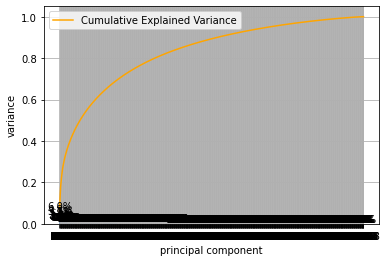

In [36]:
# Create a scree plot to determine the intrinsic dimension of the dataset.

# Create a sequence of labels for each principal component in the
# scree plot below.
components = ['PC'+str(x+1) for x in range(pca_model.n_components_)]

# Plot the variance explained by each component individually as a bar plot.
plt.bar(components, pca_model.explained_variance_ratio_,
        color='dodgerblue')

# Plot the cumulative variance explained by the components as a line plot.
plt.plot(components,np.cumsum(pca_model.explained_variance_ratio_),
         c='orange',
         label="Cumulative Explained Variance")

# Add labels to the plot.
plt.xlabel('principal component')
plt.ylabel('variance')
plt.xticks(components)
plt.legend(loc='upper left')
plt.grid(True)

# Add labels on the bar plot to sdwow the amount of variance explained
# by each principal component.
np.set_printoptions(precision=2) # This limits any output to 2dp.
var_exp = pca_model.explained_variance_ratio_
for i in range(len(components)):
    plt.annotate('{:.1%}'.format(var_exp[i]), \
                 xy=(components[i],var_exp[i]), ha='center', va='bottom')

# plt.savefig('DAA M06 Fig4.jpg')
plt.show()

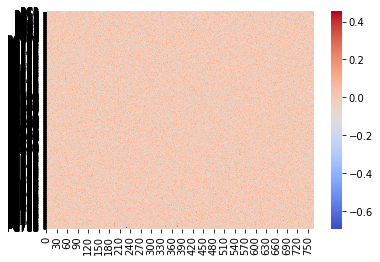

In [37]:
# examine the contribution of the original Covid dataset features to each of the principal components.
# This is achieved below by creating a heatmap.
sns.heatmap(pca_model.components_,
                 cmap='coolwarm',
                 yticklabels=components,
                 cbar_kws={"orientation": "vertical"})
plt.savefig('DAA M06 Fig5.jpg', bbox_inches='tight')

In [38]:
np.cumsum(pca_model.explained_variance_ratio_[:400])[-1]

0.900739097396418

90% of the variance can be explained by first 400 dimension, which about half of the original dimension of 768

Thus, we will reduce our dimension to 400 for modelling purpose

In [39]:
# Stack each word embedding together, then Scale, Fit, Transform
pca_model = PCA(n_components=400).fit(StandardScaler().fit_transform(feature_no_pad))

In [40]:
feature_pca = [] 
for i in range(len(feature)):
  feature_pca.append(torch.unsqueeze(torch.FloatTensor(pca_model.transform(feature[i])),dim=0))

feature_pca = torch.cat(tuple(feature_pca),dim=0) 

In [41]:
# Check
feature_pca.shape

torch.Size([6995, 118, 400])

## K-mean clustering (Question 3c & d)

For K-means Clustering, we will not use BERT embedding for it, because the original word cannot be restored.

Rather, tf-idf will be used to vetorised the tokens, that way, we can check the distribution of the words within each clusters assigned by K-means

In [ ]:
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
tqdm.pandas()
processed_tweet = data_merged['tweet_text'].progress_apply(spacy_tokenizer)

100%|██████████| 6995/6995 [00:03<00:00, 2073.37it/s]


In [ ]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(processed_tweet)

Next, we will applies internal validation on the clusters by WCSS (Within Cluster Sum of Squares), and based on the results to select the optimal number of clusters k. 

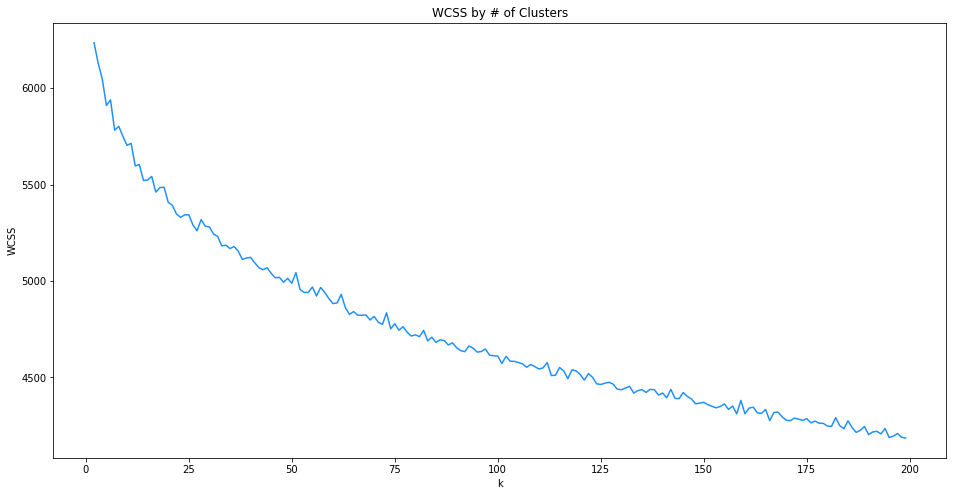

In [ ]:
WCSS = []

# Calculate the WCSS or inertia for different values of K.
K = range(2,200)
for k in K:
    kmeans = SphericalKMeans(n_clusters=k, verbose=0,random_state=123)
    fitted = kmeans.fit(x_tfidf)
    WCSS.append(fitted.inertia_)

# Plot the elbow curve. ('bx-')
plt.figure(figsize=(16,8))
plt.plot(K, WCSS,color='dodgerblue')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('WCSS by # of Clusters')
plt.show()

As shown from graph above, as k increase, the speed of reduction in WCSS is  significantly slower, and the speed of reduction has converged to a very slow pace after k = 75. 

Thus based on the elbow method, k = 75 should be a optimal choice of # number clusters. We will also evalute the quality of the clusters based on the words distribution in the later part of this notebook. 

In [ ]:
x_tfidf = TfidfTransformer().fit_transform(data_vectorized)
kmeans = SphericalKMeans(n_clusters=75, verbose=0,random_state=123)
labels = kmeans.fit_predict(x_tfidf)
centers = kmeans.cluster_centers_

In [ ]:
prepared_data = kmeans_to_prepared_data(
    data_vectorized,
    vectorizer.get_feature_names(),
    centers,
    labels,
    n_printed_words = 40,
    radius = 2
)

In [ ]:
data_merged['assigned_cluster'] = kmeans.fit_predict(x_tfidf)
count_clu_move = data_merged.groupby(['assigned_cluster','Move']).agg(['count']).reset_index()
count_clu = data_merged.groupby(['assigned_cluster']).agg(['count']).reset_index()

In [ ]:
merged = pd.merge(count_clu_move,count_clu,how='left',on='assigned_cluster')
merged = merged[['assigned_cluster','Move','name_x','name_y']]
merged['% of Cluster'] = merged['name_x']/merged['name_y'] * 100
merged = merged[['assigned_cluster','Move','% of Cluster']]

Manual & External validation of the Clusters' quality 

Top 5 Clusters linked to decreases of the share price of NEC  

In [ ]:
print(merged[merged['Move'].values==0].sort_values(['% of Cluster']).tail(5).to_string())

    assigned_cluster Move       % of Cluster
                          count             
102               34    0    35    14.285714
69                23    0    85    15.294118
105               35    0    42    16.666667
173               58    0    45    17.777778
90                30    0    56    21.428571


Top 5 Clusters linked to increases of the share price of NEC  

In [ ]:
print(merged[merged['Move'].values==2].sort_values(['% of Cluster']).tail(5).to_string())

    assigned_cluster Move       % of Cluster
                          count             
127               42    2    47    17.021277
142               47    2    79    17.721519
68                22    2    57    19.298246
160               53    2    45    22.222222
80                26    2    31    25.806452


In [ ]:
pyLDAvis.display(prepared_data)

Following are some of the interesting insights about the Television Industry that we can see from the visualization above:


1.   **Rating = Number of People Watched = Advertistiment Revenue** 

> As mentioend in question 1, a large amount of revenuew for the players in the free-to-air television industry come from advertisment, and the advertisement revenue will depends on the number of people who watch this this show, which is postively correlated with the ratings of the programs boardcasted by the networks.  

> The clustering result shown above provided a strong evidence of this, as we can see, the top-2 clusters containing the highest % of tweets that linked to the increase in share price of NEC are from programs of the Nine Entertainment itself. They are listed below:

> *   Cluster 26 - Most Common Words -> "weakestlinkau", which was previous boardcasted on channel 7, but now boardcasted on channel 9.

> *   Cluster 53 - Most Common Words -> "Saturday" & "davidattenborough" & "perfectplanet", which are all linked to the program "Perfect Planet" which is boardcasted by Nine Entertainment.

2.   **Zero-Sum Game** 

> As mentioend in question 1, free-to-air television industry is a zero sum game due to the fact that the number of audiences is watching free-to-air television is decreasing over time, while every audience can really focus on 1 program at a time. 

> The clustering result shown above provided a strong evidence of this, as we can see, 3 out of 5 of the clusters containing the highest % of tweets that linked to the decreases in share price of NEC are from programs of the Seven Groups. They are listed below:

> *   Cluster 30 - Most Common Words -> "AUSvIND", which is about the a cricket match (Australia vs Indian), and its live boardcast right is with @7cricket.   

> *   Cluster 35 - Most Common Words -> "Winx" & "Stakes", which are the common terms that have been used in the context of horse racing. And again horse racing's live boardcast right sits with the Seven Group

> *   Cluster 34 - Most Common Words -> "Daisy" & "Heather", which can be linked to the "The Heater And Daisy Show" runs by the Seven Group.


3.   **Emphasis on Time-Senstive Program** 

> As mentioend in question 1, as the SVOD (Subscription Video on Demand) & and rolled out of NBN, boardcasting the traditional dramas on free-to-air televsion cannot effective attract audiences anymore. 

> Instead, the networks now focus on boardcasting time-senstive programs such as Live Sports & News, which loss its values if you watch it after being aired for a period of time. Program with this time-senstive nature is very hard to be replace by SVOD, and thus worked well in terms of attracting customers and maintaing a high rating. 

> The clustering result shown above provided a strong evidence of this. Based on the word distribution of the clusters, we can see that the top-5 clusters that linked to either "decrease" & "increase" are all relates to either Live Sports or News. 

---

Overall, the quality of the clusters are pretty good, the K-means model is able to group the tweets that relates to the same programs together. Combining it with the price movements associated with the tweets, we are able to generate a lot of interesting insights as discussed above.


# Neural Network Model (Quesiton 4b)


For the neural Network Model, we will bulit 2 sepearte models, one based on the tweets of the competitor (Seven Groups & Channel 10), and another one based on the tweets of the program boardcasted by Nine Entertainment itself.

The architecture of the model is very straight forward:

1.   Firstly, The input layer is connected to a dropout layer which random dropout some of the input features 
2.   Then, we connect the outputs from the dropout layer to the first hidden layer with GRUs
3.   Lastly, the outputs from the GRUs will be passed to a pooling layer (avg pool + max pool) before connecting to the output layer with softmax activation function

Hyperparamters will be tuned based on the performance on the test set, following are all the hyperparameter will be test via a grid searched:

1. Feature - [Original Feature, Dimension Reduced Features (by PCA)]
2. Number of Neurons - [32, 64, 128]
3. Learning Rates - [1e-3, 1e-4, 1e-5]
4. Dropout Probability on the Input Features (Embeddings) - [0.3, 0.5, 0.8]
5. Batch Size - [128, 256, 512]

Early-Stopping will also be used to prevent overfitting.

### Rules for Model Evaluation (Question 4d) 

First of all, we assume that each of the trade action will be closed at the end of the 10-min time interval. 

Meaning if a buy action is triggered in during one of the 10-min time interval, we will assume the share was bought with the open price and sold at close price, and that is where the returns / loss is generated. Likewise for sell actions.

The performance on test set will be specifically measured using following 3 metrics

*   Sharpe Ratio - This measure the risk adjusted returns generated by the model, the higher the sharpe ratio, the better the model. In additional a 5 bps brokage fess will be deducted from the return of each buy / sell action.

*   Number of Trades Placed - If the model learnt to just play defensive and not place enough trade to generated the profit, then it is not a successful model as well. Ideally, we would want the model to place at least 50 trades over the testing period

*   Accuracy on the trade placed - This metrics measure the accuracy of the prediction regardless the magnitudes of the price movement, this can be a more stable metrics than sharpe ratio as it is not impacted by the one-off extreme market movements e.g. the black swan events.  

Notes that, the cumulative returns of the trades here is additive rather than multiplicative, so that the loss generated from previous trade does negatively impact the return of the trades later. 

More detail evaluation of each of the model will be presented as text cell after the cells with models results

### Model built based on shows from Nine Network

In [42]:
# Divide the Data into Own / Competitor Data for building different Model
data_own = data_merged[data_merged['Competitor'] == 0]
feature_own = feature[data_merged['Competitor'] == 0]
feature_own_pca = feature_pca[data_merged['Competitor'] == 0]

In [43]:
# Note that the data has been sorted by Time Stamp, so this is a Time based split
train_split = 0.7
split_point = int(len(data_own)*train_split)

train_label = data_own['Move'][:split_point]
test_label = data_own['Move'][split_point:]

train_feature = feature_own[:split_point]
train_feature_pca = feature_own_pca[:split_point]

test_feature = feature_own[split_point:]
test_feature_pca = feature_own_pca[split_point:]

In [44]:
data_own.groupby(['Move']).count()

,name,tweet_text,TS,Open,Close,TS_Open,Time,TS_Close,Name,Company,Currently_In,Type,Competitor
Move,,,,,,,,,,,,,
0,326,326,326,326,326,326,326,326,326,326,11,326,326
1,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,149,3220,3220
2,371,371,371,371,371,371,371,371,371,371,19,371,371


As the results shown above, the price movement are domainated by the "Unchanged" category, this is expected as we have select 85th percentile of the market movment as the thershold for triggering a buy / sell action.

To fix this class imbalance issue, we will add a class cost of 10 to both "Decrease" and "Increase" class. The reason 10 is being selected, it's because the number of samples in the "Unchange" class is about 10 times in terms of quantities in comparsion with the other classes.

Otherwise, the model will learn to predict "Unchanged" all the time as that would yields the highest accuracy, but that does not help us generate profits from trades at all. 

In [58]:
# Calculate Benchmark Return 
benchmark_return = (data_own['Open'][split_point:].iloc[-1] - data_own['Open'][split_point:].iloc[0])/data_own['Open'][split_point:].iloc[0]

# Calculate Benchmark Return
print(benchmark_return)

0.02910958904109589


In [111]:
def train_model(feature_type,rnn_hidden,emb_drop_out,lr_rate,batch_size,max_epochs=200,print_results=False):

  class_weights = [10,1,10]

  def process_function(engine, batch):
      """Single training loop to be attached to trainer Engine
      """
      model.train()
      optimizer.zero_grad()
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      loss = loss_fn(y_pred, y, torch.tensor(class_weights).type(torch.FloatTensor).to(device),reduction='mean')
      loss.backward()
      optimizer.step()
      return loss.item(), y_pred, y

  def eval_function(engine, batch):
      """Single evaluator loop to be attached to trainer and evaluator Engine
      """
      model.eval()
      with torch.no_grad():
          x, y = batch
          x, y = x.to(device), y.to(device)
          y_pred = model(x)
          return y_pred, y

  def score_function(engine):
      """EarlyStopping will call this function to check if score improved
      """
      val_loss = engine.state.metrics['cross_entropy']
      return -val_loss

  def collate_fn(data):
      for i, (sent, label) in enumerate(data):
          padded_sents[i,:lens[i]] = torch.LongTensor(sent)
          labels.append(label)
      
      padded_sents = padded_sents.transpose(0,1)
      return padded_sents, torch.tensor(labels).long(), lens

  if feature_type == "Original": 
    embedding_dim = 768
    train_data = TensorDataset(train_feature, torch.from_numpy(np.array(train_label)).type(torch.LongTensor))
    test_data = TensorDataset(test_feature, torch.from_numpy(np.array(test_label)).type(torch.LongTensor))

  elif feature_type == "PCA":
    embedding_dim = 400
    train_data = TensorDataset(train_feature_pca, torch.from_numpy(np.array(train_label)).type(torch.LongTensor))
    test_data = TensorDataset(test_feature_pca, torch.from_numpy(np.array(test_label)).type(torch.LongTensor))

  n_out = 3

  # Create Dataset
  train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
  test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

  class ConcatPoolingGRUAdaptive(nn.Module):
      def __init__(self, embedding_dim, n_hidden, n_out):
          super().__init__()
          self.embedding_dim = embedding_dim
          self.n_hidden = n_hidden
          self.n_out = n_out
          self.emb_drop = nn.Dropout(emb_drop_out)
          self.gru = nn.GRU(self.embedding_dim, self.n_hidden, batch_first=True)
          self.out = nn.Linear(self.n_hidden*3, self.n_out)
          
      def forward(self, seq):
          self.h = self.init_hidden(seq.size(0))
          embs = self.emb_drop(seq)
          gru_out, self.h = self.gru(embs, self.h)
          
          avg_pool = F.adaptive_avg_pool1d(gru_out.permute(0,2,1),1).view(seq.size(0),-1)
          max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1),1).view(seq.size(0),-1)
          outp = self.out(torch.cat([self.h[-1],avg_pool,max_pool],dim=1))             
          return F.log_softmax(outp, dim=-1) # it will return log of softmax
      
      def init_hidden(self, batch_size):
          return torch.zeros((1, batch_size,self.n_hidden), requires_grad=True).to(device)
      
  model = ConcatPoolingGRUAdaptive(embedding_dim, rnn_hidden, n_out).to(device) 
  optimizer = optim.Adam(model.parameters(), lr_rate)
  loss_fn = F.cross_entropy

  trainer = Engine(process_function)
  train_evaluator = Engine(eval_function)
  validation_evaluator = Engine(eval_function)

  # attach running loss (will be displayed in progess bar)
  RunningAverage(output_transform=lambda x: x[0]).attach(trainer, 'loss')

  # attach running accuracy (will be displayed in progess bar)
  RunningAverage(Accuracy(output_transform=lambda x: [x[1], x[2]])).attach(trainer, 'acc')

  # attach accuracy and loss to train_evaluator
  Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(train_evaluator, 'accuracy')
  Loss(loss_fn).attach(train_evaluator, 'cross_entropy')

  # attach accuracy and loss to validation_evaluator
  Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(validation_evaluator, 'accuracy')
  Loss(loss_fn).attach(validation_evaluator, 'cross_entropy')

  if print_results == True:
    pbar = ProgressBar(persist=True, bar_format="")
    pbar.attach(trainer, ['loss', 'acc'])

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(engine):
      """This function will run after each epoch and 
        report the training loss and accuracy (defined above)
      """
      train_evaluator.run(train_loader)
      metrics = train_evaluator.state.metrics
      avg_accuracy = metrics['accuracy']
      avg_ce = metrics['cross_entropy']

      if print_results == True:
        pbar.log_message(
            f'Training Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.4f} Avg loss: {avg_ce:.4f}')
      
  @trainer.on(Events.EPOCH_COMPLETED)
  def log_validation_results(engine):
      """This function will run after each epoch and 
        report the validation loss and accuracy (defined above)
      """
      validation_evaluator.run(test_loader)
      metrics = validation_evaluator.state.metrics
      avg_accuracy = metrics['accuracy']
      avg_ce = metrics['cross_entropy']

      if print_results == True:
        pbar.log_message(
            f'Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.4f} Avg loss: {avg_ce:.4f}')
        pbar.n = pbar.last_print_n = 0

  early_stopping = EarlyStopping(patience=10, score_function=score_function, trainer=trainer,ver)
  validation_evaluator.add_event_handler(Events.COMPLETED, early_stopping)

  checkpointer = ModelCheckpoint(
      './models', 
      'text_gru_concat', 
      save_interval=None, 
      n_saved=1, 
      create_dir=True, 
      save_as_state_dict=True,
      require_empty=False)

  trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'sentiment': model})

  trainer.run(train_loader, max_epochs=max_epochs)

  # Evaluation
  model.eval()
  with torch.no_grad():
    if feature_type == "Original": 
      y_pred = model(test_feature.to(device))

    elif feature_type == "PCA":
      y_pred = model(test_feature_pca.to(device))

  return np.argmax(y_pred.cpu(), axis=1)

In [ ]:
feature_type = ["PCA","Original"]
rnn_hidden = [32, 64, 128]
lr_rate = [1e-3, 1e-4, 1e-5]
emb_drop_out = [0.3, 0.5, 0.8]
batch_size = [128, 256, 512]

# Hyperparameters
feature_type_out = []
rnn_out = []
lr_out = []
dropout_out = []
batch_size_out = []

# Outputs
num_short = []
num_buy = []
accuracy_out = []
sharpe_out = []

for f in feature_type:
  for r in rnn_hidden:
    for l in lr_rate:
      for e in emb_drop_out:
        for b in batch_size:

          # Train Model
          y_pred_final = train_model(f,r,e,l,b,max_epochs=200)      

          # Append Results
          feature_type_out.append(f)
          rnn_out.append(r)
          lr_out.append(l)
          dropout_out.append(e)
          batch_size_out.append(b)

          # Evaluation
          mat = confusion_matrix(test_label, y_pred_final,labels=[0, 1, 2])

          num_short.append(np.sum(mat,axis=0)[0])
          num_buy.append(np.sum(mat,axis=0)[2])
          accuracy_out.append(round((mat[0,0]+mat[2,2])/(np.sum(mat,axis=0)[0]+np.sum(mat,axis=0)[2]),2))

          returns = []
          data_temp = data_own[split_point:].reset_index(drop=True)

          for i in range(len(data_temp)):
            if y_pred_final[i] == 0:
              returns.append((data_temp['Open'][i] - data_temp['Close'][i])/data_temp['Open'][i] - 0.0005*2)
            elif y_pred_final[i] == 2:
              returns.append((data_temp['Close'][i] - data_temp['Open'][i])/data_temp['Open'][i] - 0.0005*2)

          returns = np.array(returns)
          returns_std = np.std(returns)
          returns_sum = np.sum(returns)
          sharpe_out.append((returns_sum - benchmark_return) / returns_std)

In [113]:
CV_results ={'feature_type':feature_type_out,'number_of_neuron':rnn_out,'lr':lr_out,'dropout_prob':dropout_out,'batch_size':batch_size_out, 'number_of_short_action':num_short, 'number_of_buy_action':num_buy, 'accuracy':accuracy_out, 'sharpe_ratio':sharpe_out}
CV_results = pd.DataFrame(CV_results)
print(CV_results.sort_values(['sharpe_ratio'],ascending=False).to_string())

    feature_type  number_of_neuron       lr  dropout_prob  batch_size  number_of_short_action  number_of_buy_action  accuracy  sharpe_ratio
51           PCA                64  0.00001           0.8         128                      26                     4      0.07     -8.978673
15           PCA                32  0.00010           0.8         128                      40                     6      0.11    -11.344230
107     Original                32  0.00001           0.8         512                       2                    28      0.10    -14.467316
106     Original                32  0.00001           0.8         256                       2                    28      0.10    -17.800223
40           PCA                64  0.00010           0.5         256                      34                     6      0.05    -18.249456
80           PCA               128  0.00001           0.8         512                      20                    45      0.11    -22.219523
52           PCA    

Let's evaluate the models based on the results shown above:

1.   Sharpe Ratio - None of the model is able to achieve a postive sharpe ratio, meaning none of the model can be used to generate profits. 

2.   Number of Traded Placed - While model 51 has achieved the highest sharpe ratio (despite it is negative), it's overly defensive in terms of its prediction. There are only 30 trades being made in total, so it would be considered as the best model from my prespective. 

3.   Accuracy - In terms of accuracy, model 15 has achieved the highest accuracy across all models, while placed close to 50 trades in total, and ranked second place in terms of Sharpe Ratio. 

So overall, if take all 3 metrics above into account, model 15 would be the best model.  



## Model built based on shows from competitor Network

In [119]:
# Divide the Data into Own / Competitor Data for building different Model
data_comp = data_merged[data_merged['Competitor'] == 1]
feature_comp = feature[data_merged['Competitor'] == 1]
feature_comp_pca = feature_pca[data_merged['Competitor'] == 1]

In [120]:
# Note that the data has been sorted by Time Stamp, so this is a Time based split
train_split = 0.7
split_point = int(len(data_comp)*train_split)

train_label = data_comp['Move'][:split_point]
test_label = data_comp['Move'][split_point:]

train_feature = feature_comp[:split_point]
train_feature_pca = feature_comp_pca[:split_point]

test_feature = feature_comp[split_point:]
test_feature_pca = feature_comp_pca[split_point:]

In [121]:
data_comp.groupby(['Move']).count()

,name,tweet_text,TS,Open,Close,TS_Open,Time,TS_Close,Name,Company,Currently_In,Type,Competitor
Move,,,,,,,,,,,,,
0,259,259,259,259,259,259,259,259,229,229,15,229,259
1,2548,2548,2548,2548,2548,2548,2548,2548,2287,2287,170,2287,2548
2,271,271,271,271,271,271,271,271,235,235,19,235,271


In [ ]:
feature_type = ["PCA","Original"]
rnn_hidden = [32, 64, 128]
lr_rate = [1e-3, 1e-4, 1e-5]
emb_drop_out = [0.3, 0.5, 0.8]
batch_size = [128, 256, 512]

# Hyperparameters
feature_type_out = []
rnn_out = []
lr_out = []
dropout_out = []
batch_size_out = []

# Outputs
num_short = []
num_buy = []
accuracy_out = []
sharpe_out = []

for f in feature_type:
  for r in rnn_hidden:
    for l in lr_rate:
      for e in emb_drop_out:
        for b in batch_size:

          # Train Model
          y_pred_final = train_model(f,r,e,l,b,max_epochs=200)      

          # Append Results
          feature_type_out.append(f)
          rnn_out.append(r)
          lr_out.append(l)
          dropout_out.append(e)
          batch_size_out.append(b)

          # Evaluation
          mat = confusion_matrix(test_label, y_pred_final,labels=[0, 1, 2])

          num_short.append(np.sum(mat,axis=0)[0])
          num_buy.append(np.sum(mat,axis=0)[2])
          accuracy_out.append(round((mat[0,0]+mat[2,2])/(np.sum(mat,axis=0)[0]+np.sum(mat,axis=0)[2]),2))

          returns = []
          data_temp = data_comp[split_point:].reset_index(drop=True)

          for i in range(len(data_temp)):
            if y_pred_final[i] == 0:
              returns.append((data_temp['Open'][i] - data_temp['Close'][i])/data_temp['Open'][i] - 0.0005*2)
            elif y_pred_final[i] == 2:
              returns.append((data_temp['Close'][i] - data_temp['Open'][i])/data_temp['Open'][i] - 0.0005*2)

          returns = np.array(returns)
          returns_std = np.std(returns)
          returns_sum = np.sum(returns)
          sharpe_out.append((returns_sum - benchmark_return) / returns_std)

In [124]:
CV_results ={'feature_type':feature_type_out,'number_of_neuron':rnn_out,'lr':lr_out,'dropout_prob':dropout_out,'batch_size':batch_size_out, 'number_of_short_action':num_short, 'number_of_buy_action':num_buy, 'accuracy':accuracy_out, 'sharpe_ratio':sharpe_out}
CV_results = pd.DataFrame(CV_results)
print(CV_results.sort_values(['sharpe_ratio'],ascending=False).to_string())

    feature_type  number_of_neuron       lr  dropout_prob  batch_size  number_of_short_action  number_of_buy_action  accuracy  sharpe_ratio
25           PCA                32  0.00001           0.8         256                      36                    15      0.16    -12.767392
107     Original                32  0.00001           0.8         512                       5                    32      0.08    -15.608695
35           PCA                64  0.00100           0.8         512                       8                     5      0.00    -20.160650
18           PCA                32  0.00001           0.3         128                       4                    26      0.07    -22.444199
94      Original                32  0.00010           0.5         256                      44                    29      0.07    -25.429458
79           PCA               128  0.00001           0.8         256                      16                    89      0.07    -27.711912
49           PCA    

Let's evaluate the models based on the results shown above:

1.   Sharpe Ratio - Again, None of the model is able to achieve a postive sharpe ratio, meaning none of the model can be used to generate profits. Having said that, model 25 has achieved the highest sharpe ratio.

2.   Accuracy - Again model 25 has achieved the highest accuracy in terms of accuracy

3.   Number of Traded Placed - Model 25 has achieved the highest accuracy & sharpe ratio, which is always a good sight when these two metrics agree. In addition, the model has placed 51 trades over the test period, which is good as that is not considered to be too defensive in terms of its strategy.   

So overall, if take all 3 metrics above into account, model 25 would be the best model.  



# XGBoost Model (Question 4c)


For the XGBoost Model, we will just fit a single model but with competitor flag as part of the features, which should allow the model to differentiate the impacts from tweets of competitor vs tweets from Nine Entertainment itself.

Note that, we did not use word embedding for BERTweet here, instead, we have used the sentence embedding encoded by one of the out-of-shelf model from HuggingFace.   

Hyperparamters will be tuned based on the performance on 3 fold cross-validation, following are all the hyperparameter will be test via a grid searched:

1. Depth of the trees - [2,4,8]
2. Alpha (the penality terms for model regularisation and feature selection) - [10,20,30]
3. Learning Rates - [0.01,0.001,0.0001]
4. Colsample_bytree  (the fraction of features that will be sampled and used to train each tree) - [0.3, 0.5, 0.8]

Early-Stopping will also be used to prevent overfitting.

In [263]:
col_names = []

#create column for each lag
for i in range(1,769):
    col_name = 'WordEmb_' + str(i)
    col_names.append(col_name) 

In [265]:
# add competitor flag as part of the model features
data = data_merged.copy()

feature = np.hstack((np.array(data['Competitor']).reshape(len(data['Competitor']),1),np.array(sentence_embeddings)))
feature = pd.DataFrame(feature, columns = ['Competitor'] + col_names)

In [266]:
# Assign Sample Weights
data['Weights'] = 1 

for i in range(len(data['Move'])):
  if data['Move'][i] in [0,2]:
     data['Weights'][i] = 10

In [269]:
# Note that the data has been sorted by Time Stamp, so this is a Time based split
train_split = 0.7
split_point = int(len(data_own)*train_split)

train_label = data['Move'][:split_point]
test_label = data['Move'][split_point:]

train_feature = feature[:split_point]
test_feature = feature[split_point:]

train_weight = data['Weights'][:split_point]
test_weight = data['Weights'][split_point:]

In [270]:
train_dmatrix = xgb.DMatrix(data=train_feature,label=train_label,weight=train_weight)
test_dmatrix = xgb.DMatrix(data=test_feature,label=test_label,weight=train_weight)

## Feature Selection for XGBoost model

For the neural network model, we have used PCA with dropout layers to reduce and select the features, but for XGBoost model, we will do something different.

We will use the hyper-parameter alpha to regualrise the model, which in a way reduced the number of feature fitted for each model, and we will tune it as part of the hyperparameter tuning exercise.



In [271]:
lr = [0.01,0.001,0.0001]
depth = [2,4,8]
alpha = [10,20,30]
colsample_bytree = [0.3,0.5,0.8]

# Hyperparameters
rounds = []
lr_out = []
depth_out = []
alpha_out = []

# Outputs
num_short = []
num_buy = []
accuracy_out = []
sharpe_out = []

for l in lr:
  for de in depth:
    for al in alpha:
      for c in colsample_bytree:
        params = {"objective":"multi:softmax",'colsample_bytree': c,'learning_rate': l,'max_depth': de, 'alpha': al,'num_class': 3}

        cv_results = xgb.cv(dtrain=train_dmatrix, params=params, nfold=3, 
                            num_boost_round=10000,early_stopping_rounds=10,metrics="mlogloss", as_pandas=True, seed=123)

        # Hyperparameters        
        lr_out.append(l)
        depth_out.append(de)
        alpha_out.append(al)
        best_rounds = cv_results[cv_results['test-mlogloss-mean']==cv_results['test-mlogloss-mean'].min()].index.values[0]
        rounds.append(best_rounds)

        # Refit model with its best hyper-parameter 
        bst = xgb.train(dtrain=train_dmatrix,params=params, num_boost_round=best_rounds)

        # Evaluation
        y_pred_final = bst.predict(test_dmatrix)
        mat = confusion_matrix(test_label, y_pred_final,labels=[0, 1, 2])

        num_short.append(np.sum(mat,axis=0)[0])
        num_buy.append(np.sum(mat,axis=0)[2])
        accuracy_out.append(round((mat[0,0]+mat[2,2])/(np.sum(mat,axis=0)[0]+np.sum(mat,axis=0)[2]),2))

        returns = []
        data_temp = data[split_point:].reset_index(drop=True)

        for i in range(len(data_temp)):
          if y_pred_final[i] == 0:
            returns.append((data_temp['Open'][i] - data_temp['Close'][i])/data_temp['Open'][i] - 0.0005*2)
          elif y_pred_final[i] == 2:
            returns.append((data_temp['Close'][i] - data_temp['Open'][i])/data_temp['Open'][i] - 0.0005*2)

        returns = np.array(returns)
        returns_std = np.std(returns)
        returns_sum = np.sum(returns)
        
        sharpe_out.append((returns_sum - benchmark_return) / returns_std)

In [272]:
CV_results ={'lr':lr_out,'depth':depth_out,'alpha':alpha_out, 'rounds':rounds, 'number_of_short_action':num_short, 'number_of_buy_action':num_buy, 'accuracy':accuracy_out, 'sharpe_ratio':sharpe_out}
CV_results = pd.DataFrame(CV_results)
print(CV_results.sort_values(['sharpe_ratio'],ascending=False).to_string())

        lr  depth  alpha  rounds  number_of_short_action  number_of_buy_action  accuracy  sharpe_ratio
72  0.0001      8     10     684                       0                    58      0.07    -23.337433
45  0.0010      8     10      97                       1                    75      0.08    -25.024560
18  0.0100      8     10      18                      29                   113      0.10    -39.557822
73  0.0001      8     10     893                       4                   122      0.06    -43.801813
48  0.0010      8     20     175                       2                   157      0.06    -51.410429
75  0.0001      8     20     782                       0                   127      0.06    -52.581548
46  0.0010      8     10     148                      24                   128      0.06    -54.144660
49  0.0010      8     20     179                       9                   233      0.09    -58.791627
76  0.0001      8     20     522                       8                 

Let's evaluate the models based on the results shown above:

1.   Sharpe Ratio - None of the model is able to achieve a postive sharpe ratio, meaning none of the model can be used to generate profits. Worthnoting that sharpe ratio from XGB is generally lower than the ones from Neural Network.

2.   Number of Traded Placed - While model 72 has achieved the highest sharpe ratio (despite it is negative), it has only placed buy orders which is very odd and may fail badly in a bear market. Thus, it's not the best choice base on this measure. 

3.   Accuracy - In terms of accuracy, model 18 has achieved the highest accuracy across all models, while placed both buy and sell actions, and ranked third place in terms of Sharpe Ratio. 

So overall, if we take all 3 metrics above into account, model 18 would be the best model here.  



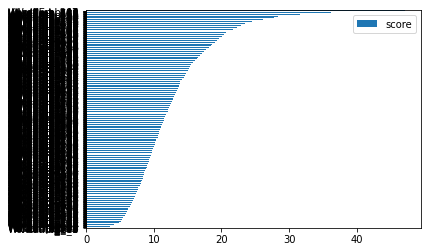

In [274]:
feature_important = bst.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
VIP = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
VIP.plot(kind='barh')

We can also evaluate the model based on the variable importance plots, but it's very hard for use to tell which feature is important given the large amount of dimension, and even if we are able to do, it's diffcult to explain the meaning of dimension of the sentence embedding. 